In [1]:
# coding: utf-8
import load_data
import numpy as np
from utils import *
import matplotlib.pyplot as plt

class Model():
    def __init__(self , x_train , x_test , use_dae = True , use_dropout = True):
        self.lr = 0.0001
        self.batch_size = 128
        self.epochs = 10
        self.num_train = x_train.shape[0]
        self.num_test = x_test.shape[0]
        self.x_train = x_train
        self.x_test = x_test
        self.total_loss = []
        self.total_predict = []
        self.total_hidden = []
        
        self.use_dae = use_dae
        self.use_dropout = use_dropout
        if self.use_dae == True:
            self.x_train_noise = add_noise(self.x_train , 0.3)
        else:
            self.x_train_noise = self.x_train
        self.set_weight()

    def set_weight(self):
        self.W1 = np.random.normal(0, 0.1, (784,128))
        self.W2 = np.random.normal(0, 0.1, (128,784))
        self.b1 = np.array([0.01 for i in range(128)])
        self.b1 = self.b1.reshape([1,128])
        self.b2 = np.array([0.01 for i in range(784)])
        self.b2 = self.b2.reshape([1,784])

    def forward_propagation(self,x):
        # 正傳導
        X = x
        L1 = X@self.W1 + self.b1
        H1 = np.maximum(L1, 0)
        L2 = H1@self.W2 + self.b2
        Y = sigmoid(L2)
        return Y

    def forward_propagation_v2(self,x):
        # 正傳導
        X = x
        L1 = X@self.W1 + self.b1
        H1 = np.maximum(L1, 0)
        L2 = H1@self.W2 + self.b2
        Y = sigmoid(L2)
        return H1,Y



    def update(self,x_noise,x):
        # 正傳導
        X = x_noise
        L1 = X@self.W1 + self.b1
        
        if self.use_dae == True:
            L1 = droupout(L1 , 0.5)
            
        H1 = np.maximum(L1, 0)
        L2 = H1@self.W2 + self.b2
        Y = sigmoid(L2)
        Y_ = x
        de_o = (Y-Y_)*de_sigmoid(Y)

        self.W2 = self.W2 - self.lr * H1.T@de_o
        self.b2 = self.b2 - self.lr * np.ones([1,self.batch_size])@de_o
        de_h2 = de_o@self.W2.T*relu_de(L1)
        self.W1 = self.W1 - self.lr * X.T@de_h2
        self.b1 = self.b1 - self.lr * np.ones([1,self.batch_size])@de_h2

    def fit(self):
        for epoch in range(self.epochs):
            for i in range(int(self.num_train/self.batch_size)):
                self.update(normalize(self.x_train_noise[i*self.batch_size:(i+1)*self.batch_size]),normalize(self.x_train[i*self.batch_size:(i+1)*self.batch_size]))
            self.evaluate()
        return self.total_loss

    def get_filter(self):
        return self.W1
    
    def reconstruct(self):
        for i in range(int(self.num_test/self.batch_size)):
            hidden,y_predict = self.forward_propagation_v2(normalize(self.x_test[i*self.batch_size:(i+1)*self.batch_size]))
            self.total_predict.append(y_predict)
            self.total_hidden.append(hidden)
        return np.array(self.total_hidden).reshape([-1,128]) , np.array(self.total_predict).reshape([-1,784])

    def evaluate(self):
        total = self.num_test
        loss = 0
        num_true = 0
        for i in range(int(self.num_test/self.batch_size)):
            y_predict = self.forward_propagation(normalize(self.x_test[i*self.batch_size:(i+1)*self.batch_size]))
            loss += cal_loss_mse(y_predict,normalize(self.x_test[i*self.batch_size:(i+1)*self.batch_size]))
        loss = loss/total
        self.total_loss.append(loss)
        print("loss:%f"%(loss))

In [2]:
def plot_dot(hidden,y_test):
    C = ['#e50000' , '#f97306' , '#ffff14' , '#96f97b' , '#15b01a' , '#00ffff' , '#0343df' , '#be03fd' , '#000000' , '#ff028d']
    sample = {}

    plt.figure(figsize=(10,10))
    for i in range(10):
        sample[i] = np.random.choice(np.where(y_test[:hidden.shape[0]]==i)[0] ,100).tolist()
        plt.plot(hidden[sample[i],0] , hidden[sample[i],1] , '.' , color=C[i] , label=i)
    plt.legend()
    plt.show()

In [3]:
def plot_image(predict,y_test):
    for i in range(8):
        plt.subplot(2,8,(i+1))
        plt.imshow(x_test[i].reshape([28,28]) , cmap='gray')
        plt.subplot(2,8,(i+1+8))
        plt.imshow(predict[i].reshape([28,28]) , cmap='gray')
    plt.show()

In [4]:
def plot_filter(W):
    for i in range(16):
        plt.subplot(4,4,(i+1))
        plt.imshow(W[:,i].reshape([28,28]) , cmap='gray')
    plt.show()

loss:54.466281
loss:42.861147
loss:37.445195
loss:34.250216
loss:31.862583
loss:29.986035
loss:28.551338
loss:27.314457
loss:26.281071
loss:25.436735


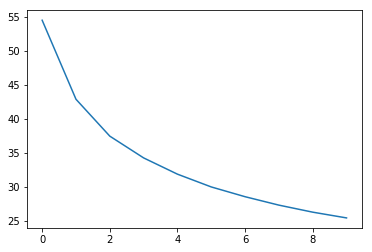

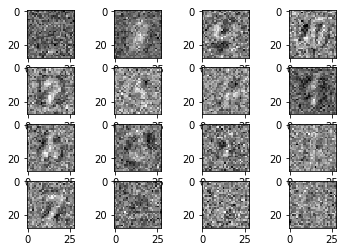

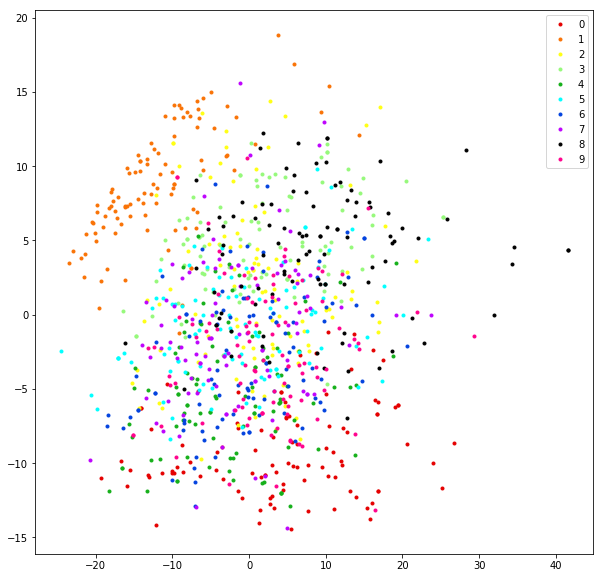

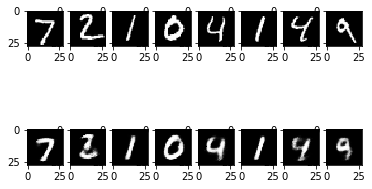

In [5]:
if __name__ == '__main__':
    x_train, y_train = load_data.loadMNIST(dataset="training", path="MNIST_data")
    x_test, y_test = load_data.loadMNIST(dataset="testing", path="MNIST_data")

    model = Model(x_train,x_test,use_dae=True,use_dropout=True)
    total_loss = model.fit()
    plot(total_loss)
    
    W1 = model.get_filter()
    plot_filter(W1)
    hidden,predict = model.reconstruct()
    hidden = pca(hidden)
    plot_dot(hidden,y_test)
    plot_image(predict,y_test)